In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout 
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import svm
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam,Adamax,Nadam
from keras.layers.noise import GaussianNoise, GaussianDropout
import numpy as np
import csv
import os

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# When you execute a code to plot with a simple SHIFT-ENTER, the plot will be shown directly under the code cell
%matplotlib inline

Using TensorFlow backend.


In [46]:
nti_type = 'linear'
nti_dim_x = '17'
nti_dim_y = '17'
#Src
nti_src = os.getcwd()  #Working from Current Working Directory
#Train
csv_output_train_data = 'ntis_%s_%sx%s_train_data.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_train_target_bulk_vs_all = 'ntis_%s_%sx%s_train_target_bulk_vs_all.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_train_target_qos = 'ntis_%s_%sx%s_train_target_qos.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_train_target_classes = 'ntis_%s_%sx%s_train_target_classes.csv' % (nti_type,nti_dim_x,nti_dim_y)
#Test
csv_output_test_data = 'ntis_%s_%sx%s_test_data.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_bulk_vs_all = 'ntis_%s_%sx%s_test_target_bulk_vs_all.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_qos = 'ntis_%s_%sx%s_test_target_qos.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_classes = 'ntis_%s_%sx%s_test_target_classes.csv' % (nti_type,nti_dim_x,nti_dim_y)

#0day-Test
csv_output_test_0day_data = 'ntis_%s_%sx%s_test_0day_data.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_0day_bulk_vs_all = 'ntis_%s_%sx%s_test_0day_target_bulk_vs_all.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_0day_qos = 'ntis_%s_%sx%s_test_0day_target_qos.csv' % (nti_type,nti_dim_x,nti_dim_y)
csv_output_test_target_0day_classes = 'ntis_%s_%sx%s_test_0day_target_classes.csv' % (nti_type,nti_dim_x,nti_dim_y)


#train_datafile = 'train_data.csv'
#target_datafile = 'train_target.csv'
#test_datafile = 'test_data.csv'

data = np.loadtxt(fname=csv_output_train_data,delimiter=',')
#Remove solo target when doing target_classes/qos/bulk
target = np.loadtxt(fname=csv_output_train_target_bulk_vs_all,delimiter=',')
#target_classes = np.loadtxt(fname=csv_output_train_target_classes,delimiter=',')
#target_qos = np.loadtxt(fname=csv_output_train_target_qos,delimiter=',')
#target_bulk = np.loadtxt(fname=csv_output_train_target_bulk_vs_all,delimiter=',')
test = np.loadtxt(fname=csv_output_test_data,delimiter=',')
##Remove solo test target when doing target_classes/qos/bulk
test_target_load = np.loadtxt(fname=csv_output_test_target_bulk_vs_all,delimiter=',')

test_0day = np.loadtxt(fname=csv_output_test_0day_data,delimiter=',')
test_target_load_0day = np.loadtxt(fname=csv_output_test_target_0day_bulk_vs_all,delimiter=',')
#test_target_classes = np.loadtxt(fname=csv_output_test_target_classes,delimiter=',')
#test_target_qos = np.loadtxt(fname=csv_output_test_target_qos,delimiter=',')
#test_target_bulk = np.loadtxt(fname=csv_output_test_target_bulk_vs_all,delimiter=',')

#Remove solo target classes when doing target_classes/qos/bulk
num_target_classes = 2
#num_target_classes_classes = 5
#num_target_classes_qos = 3
#num_target_classes_bulk = 2
image_len = int(nti_dim_x)
image_wid = int(nti_dim_y)

In [47]:
#Reshape as needed! See notes here for shaping https://keras.io/datasets/#mnist-database-of-handwritten-digits
train_data = data.reshape(len(data),image_len,image_wid,1)
train_target = target.reshape(len(target))
test_data = test.reshape(len(test),image_len,image_wid,1)
test_target_vals = test_target_load.reshape(len(test_target_load))
test_data_0day = test_0day.reshape(len(test_0day),image_len,image_wid,1)
test_target_vals_0day = test_target_load_0day.reshape(len(test_target_load_0day))


train_data,validation_data,train_target,validation_target = train_test_split(train_data,(train_target[:, np.newaxis]), test_size=0.12, random_state=42)

#Need floats!!!!
train_data = train_data.astype('float64')
test_data = test_data.astype('float64')
validation_data = validation_data.astype('float64')

#Change integer classification targets to categorical binary matrices EG: (0,0,1),(0,1,0),(1,0,0)
train_target = np_utils.to_categorical(train_target,num_target_classes)
validation_target = np_utils.to_categorical(validation_target,num_target_classes)
#test_target = np_utils.to_categorical(test_target_vals,num_target_classes)


In [4]:
#Modified callback from https://github.com/fchollet/keras/issues/114
class EarlyStoppingByValAcc(Callback):
    def __init__(self, monitor='val_acc', value=0.80, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [11]:
print("Training data matrix shape", train_data.shape)
print("Validation data matrix shape", validation_data.shape)
print("Training target matrix shape", train_target.shape)
print("Validation target matrix shape", validation_target.shape)
#print(train_data[0])

Training data matrix shape (316800, 17, 17, 1)
Validation data matrix shape (43200, 17, 17, 1)
Training target matrix shape (316800, 2)
Validation target matrix shape (43200, 2)


In [20]:
#This cell will be for a CNN implementation of the model
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(image_len,image_wid,1)))
model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
#Dead here
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_last"))

model.add(GaussianNoise(0.20))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(image_len,image_wid,1)))
model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
#Dead here2
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

model.add(GaussianDropout(0.4))
#model.add(Dense(256, activation='relu'))

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(image_len,image_wid,1)))
model.add(Conv2D(256, (3, 3),padding='same', activation='relu'))
#Dead here3
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

model.add(GaussianNoise(0.20))
#model.add(Dense(256, activation='relu'))
model.add(GaussianDropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(image_len,image_wid,1)))
model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
#Dead here 4
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

model.add(GaussianNoise(0.35))
#model.add(Dense(256, activation='relu'))

model.add(Conv2D(1024, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(image_len,image_wid,1)))
model.add(Conv2D(1024, (3, 3),padding='same', activation='relu'))
#Dead here5
#model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

model.add(GaussianDropout(0.25))
model.add(Flatten(name='flatten_conv'))

model.add(Dense(128, activation='relu',name='final_dense'))
#model.add(Dense(512, activation='relu',name='final_dense'))


#model.add(Dense(128, activation='relu',name='final_dense'))
#model.add(Dense(128, activation='relu',name='final_dense',kernel_regularizer=l2(.01)))
#model.add(Dropout(0.5))
model.add(Dense(num_target_classes, activation='softmax',name='final_output'))
#model.add(Dense(num_target_classes, activation='linear',kernel_regularizer=l2(.01)))

#model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=Adadelta(),metrics=['accuracy'])
#model.compile(loss=keras.losses.hinge,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

early_stopping_on_val_acc = EarlyStoppingByValAcc(monitor='val_acc',value=.95,verbose=0) ##HEHE-95% :)

#early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15,min_delta=.005, verbose=1, mode='max')
history = model.fit(train_data, train_target,batch_size=128,epochs=20,verbose=1,validation_data=(validation_data,validation_target),callbacks=[early_stopping_on_val_acc])
#history = model.fit(train_data, train_target,batch_size=128,epochs=150,verbose=1,validation_data=(validation_data,validation_target))

Train on 316800 samples, validate on 43200 samples
Epoch 1/150
316800/316800 [==============================] - 303s - loss: 0.2563 - acc: 0.8814 - val_loss: 0.0459 - val_acc: 0.9807


Train accuracy:  0.881433080808
Validation accuracy:  0.980740740741


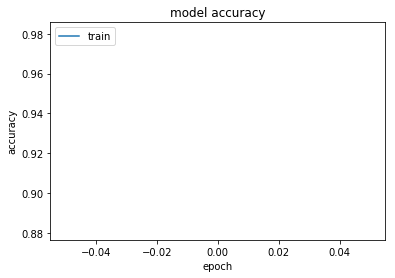

In [21]:
print('Train accuracy: ', history.history['acc'][-1])
print('Validation accuracy: ', history.history['val_acc'][-1])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [52]:
#Save model
model.save("%s_%sx%s_model_bulk.h5"%(nti_type,nti_dim_x,nti_dim_y))

In [50]:
predictions=model.predict(test_data)
final_predictions = predictions.argmax(1)
predictions_0day=model.predict(test_data_0day)
final_predictions_0day = predictions.argmax(1)

print("Predictions matrix shape", predictions.shape)
with open('%s_%sx%s_predictions.csv'%(nti_type,nti_dim_x,nti_dim_y),'w',newline='') as csvfile:
    csvwriter = csv.writer(csvfile,delimiter=',')
    csvwriter.writerow(['Id','Category'])
    for index,prediction in enumerate(final_predictions):
        #print(index,prediction)
        csvwriter.writerow([index,prediction])
with open('%s_%sx%s_predictions_0day.csv'%(nti_type,nti_dim_x,nti_dim_y),'w',newline='') as csvfile:
    csvwriter = csv.writer(csvfile,delimiter=',')
    csvwriter.writerow(['Id','Category'])
    for index,prediction in enumerate(final_predictions_0day):
        #print(index,prediction)
        csvwriter.writerow([index,prediction])

Predictions matrix shape (120000, 2)


In [51]:
def evaluate_test_predictions(test_target_vals,final_predictions):
    numCorrect = 0
    numTotal = 0
    for index,prediction in enumerate(final_predictions):
        if prediction==int(round(test_target_vals[index])):
            numCorrect+=1
        numTotal+=1
    return(numCorrect/numTotal*100)
test_accuracy = evaluate_test_predictions(test_target_vals,final_predictions)
test_accuracy_0day = evaluate_test_predictions(test_target_vals_0day,final_predictions_0day)
print("Total Test Accuracy:",test_accuracy)
print("Total 0-Day Test Accuracy:",test_accuracy_0day)

Total Test Accuracy: 97.53500000000001
Total 0-Day Test Accuracy: 58.76916666666666
